In [389]:
import os
import glob 
import cv2
# from skimage import io 
import matplotlib.pyplot as plt  


In [390]:
royals_dataset_path = "C:/Users/302b46/Desktop/Preprocessing/RoyalsDataset/"
royals_class_names = ['Khafra', 'Khufu', 'Menkaura', 'Pepi-I', 'Ramses-II', 'Ramses-III', 'Teti', 'Thutmose-II', 'Thutmose-III', 'Unas']

royals_path = os.path.join(royals_dataset_path, royals_class_names[9], '*')
royals_path = glob.glob(royals_path)

In [391]:
image_path = "C:/Users/302b46/Desktop/Grad/PicturesTakenByPhone/IMG_20220225_114908.jpg"

In [392]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def plot_rgb(image):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def plot_gray(image):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    return plt.imshow(image, cmap='Greys_r')

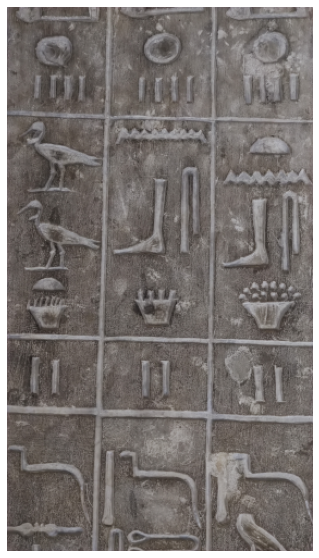

In [393]:
# image = io.imread(royals_path[10])
image_path_2 ="C:/Users/302b46/Desktop/Grad/PicturesTakenByPhone/IMG_20220225_133617.jpg"
image_path_3 = "C:/Users/302b46/Desktop/Grad/PicturesTakenByPhone/IMG_20220225_114811.jpg"
image = cv2.imread(image_path_2)
original = image.copy()
resize_ratio = 500 / image.shape[0]
image = opencv_resize(image, resize_ratio)

plot_rgb(image)

In [394]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Gaussian Blur & Image Dilation

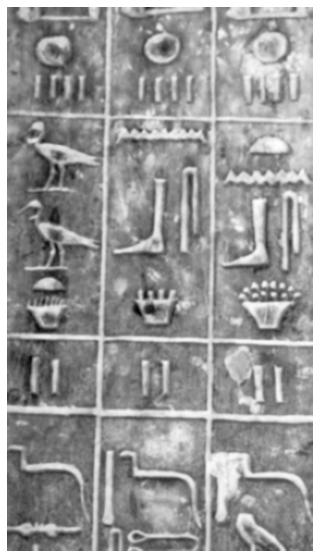

In [395]:
gaussian_image = cv2.GaussianBlur(gray_image, (5,5), 0)
plot_gray(gaussian_image)


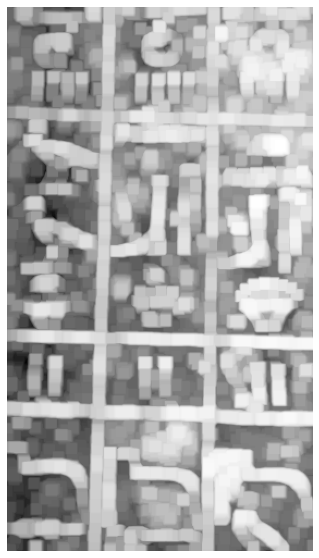

In [396]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated_image = cv2.dilate(gaussian_image, rectKernel)
plot_gray(dilated_image)

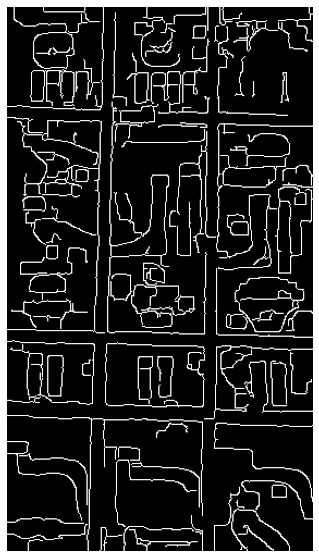

In [397]:
# edged_image = Canny_detector(dilated_image)
edged_image = cv2.Canny(dilated_image, 30,100, apertureSize=3)
plot_gray(edged_image)

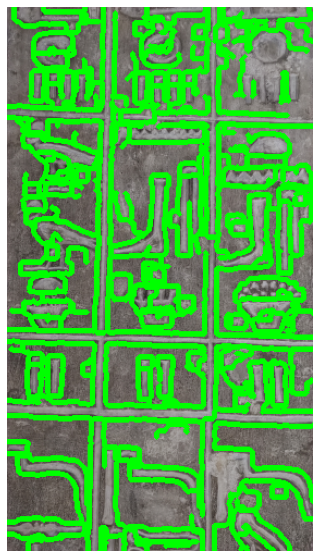

In [398]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

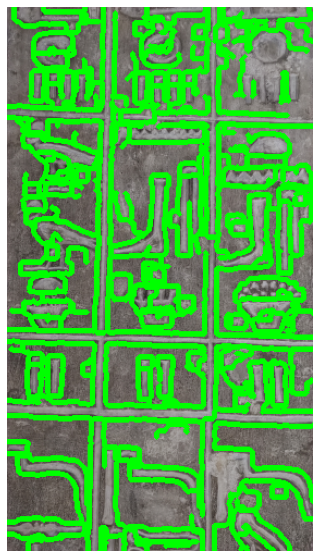

In [399]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:300]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [400]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)


def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

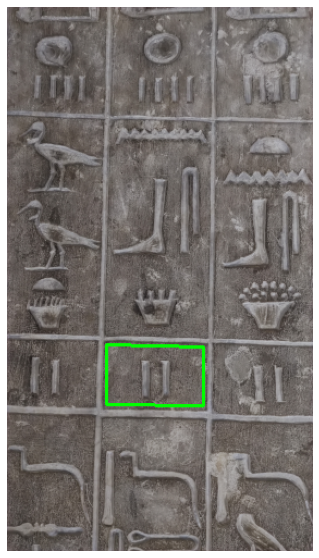

In [401]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [402]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

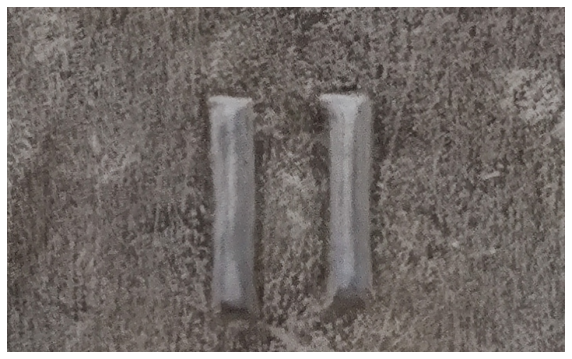

In [403]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plot_rgb(scanned)

ALL THRESHOLDS

In [404]:
from skimage import data
from skimage.filters import try_all_threshold

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


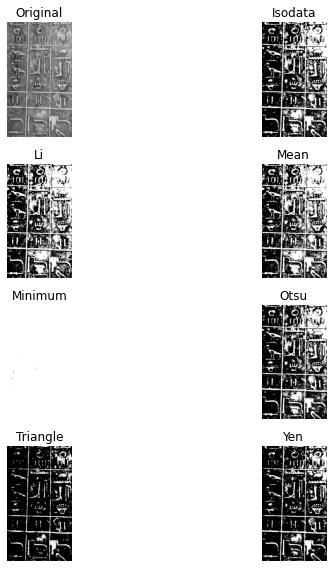

In [405]:

fig, ax = try_all_threshold(gray_image, figsize=(10,8), verbose=True)

SIMPLE THRESHOLDING

In [406]:
ret, binarythresh = cv2.threshold(gaussian_image, 120, 255, cv2.THRESH_BINARY)
ret, binarythreshInv = cv2.threshold(gaussian_image, 120, 255, cv2.THRESH_BINARY_INV)
ret, truncthresh = cv2.threshold(gaussian_image, 120, 255, cv2.THRESH_TRUNC)
ret, tozerothresh = cv2.threshold(gaussian_image, 120, 255, cv2.THRESH_TOZERO)
ret, tozerothreshInv = cv2.threshold(gaussian_image, 120, 255, cv2.THRESH_TOZERO_INV)

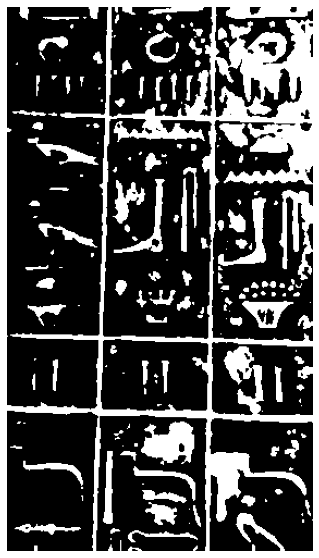

In [407]:
plot_gray(binarythresh)

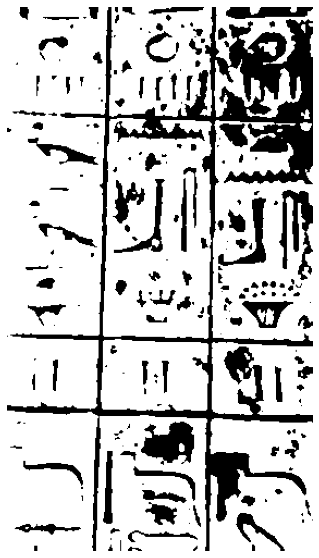

In [408]:
plot_gray(binarythreshInv)

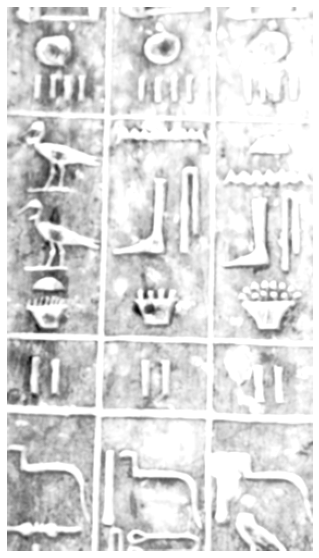

In [409]:
plot_gray(truncthresh)

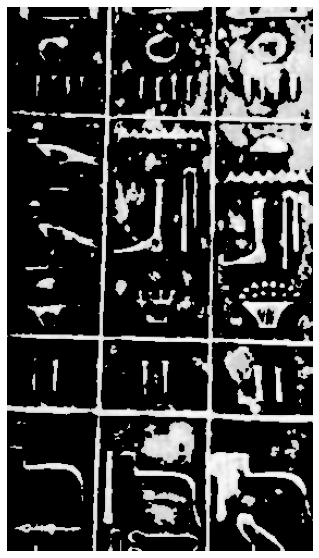

In [410]:
plot_gray(tozerothresh)

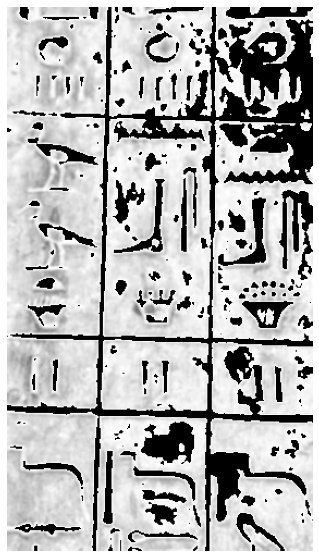

In [411]:
plot_gray(tozerothreshInv)

OTSU THRESHOLDING

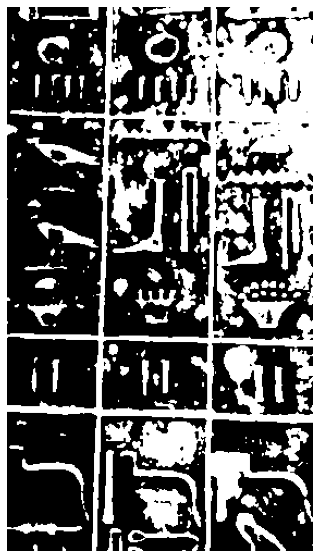

In [412]:
ret, otsuthresh = cv2.threshold(gaussian_image, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_gray(otsuthresh)

Sobel Edge Detection

In [413]:
from scipy import ndimage, misc

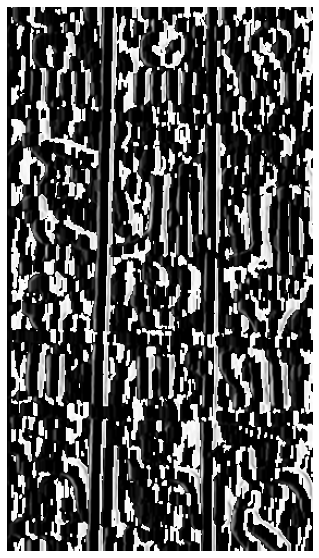

In [414]:
sobel = ndimage.sobel(dilated_image)
plot_gray(sobel)

Canny Edge Detection

In [415]:
import numpy as np
# defining the canny detector function
   
# here weak_th and strong_th are thresholds for
# double thresholding step
def Canny_detector(img, weak_th = None, strong_th = None):
      
    # conversion of image to grayscale
       
    # Noise reduction step
       
    # Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
      
    # Conversion of Cartesian coordinates to polar 
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
       
    # setting the minimum and maximum thresholds 
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
      
    # getting the dimensions of the input image  
    height, width = img.shape
       
    # Looping through every pixel of the grayscale 
    # image
    for i_x in range(width):
        for i_y in range(height):
               
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
               
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
              
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
               
            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0
   
    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)              
    ids = np.zeros_like(img)
       
    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
              
            grad_mag = mag[i_y, i_x]
              
            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2
       
       
    # finally returning the magnitude of
    # gradients of edges
    return mag

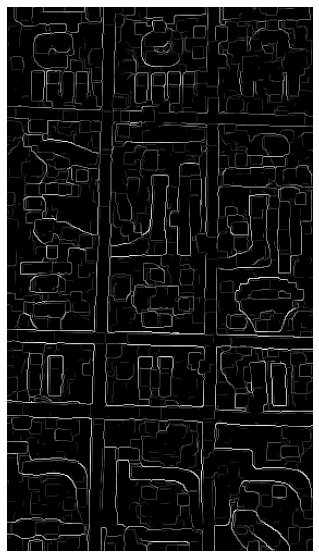

In [416]:
canny_image = Canny_detector(dilated_image)
plot_gray(canny_image)

Contrast Adaptive Histogram Equalizer

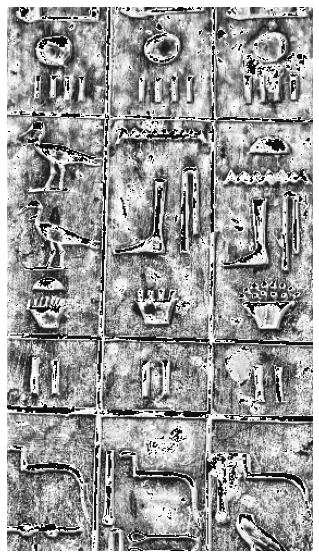

In [417]:
# scanned_gray = cv2.cvtColor(scanned, cv2.COLOR_BGR2GRAY)
equalized_image = cv2.equalizeHist(gray_image)
clahe = cv2.createCLAHE(clipLimit=5)
clahe_image = clahe.apply(equalized_image) + 20
plot_gray(clahe_image)

K-Means Clustering + Contour Detection

In [418]:
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
vectorized_image = rgb_image.reshape((-1, 3))
vectorized_image = np.float32(vectorized_image)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)


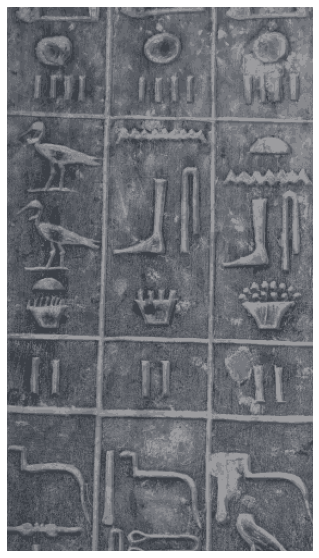

In [419]:
K = 7
attempts=10
ret,label,center=cv2.kmeans(vectorized_image,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
kmeans_image = res.reshape((rgb_image.shape))
plot_rgb(kmeans_image)

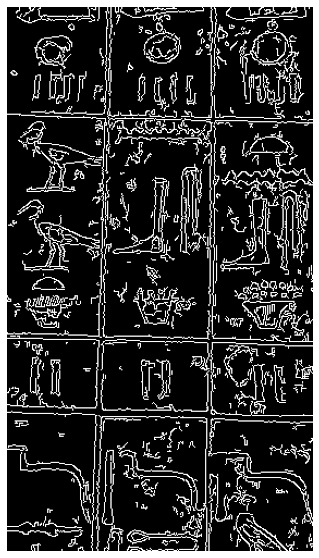

In [420]:
canny_image_kmeans = cv2.Canny(kmeans_image, 200,100, apertureSize=3)
plot_gray(canny_image_kmeans)

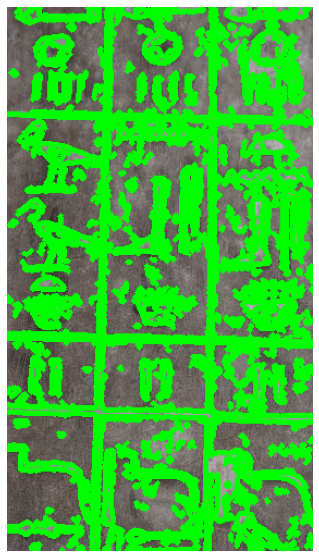

In [421]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(canny_image_kmeans, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

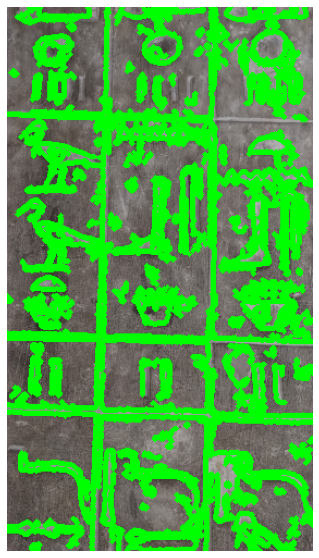

In [422]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:300]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

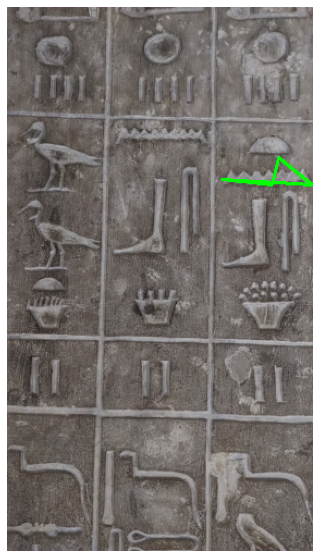

In [423]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

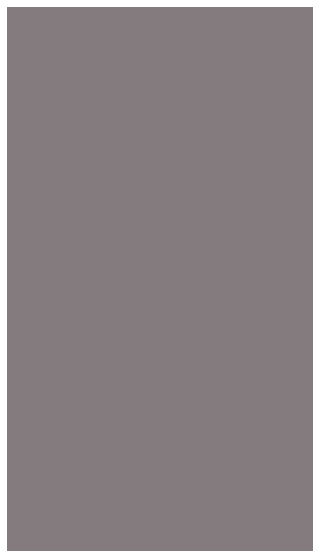

In [424]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plot_rgb(scanned)

Watershed + Otsu + Binary_Inv

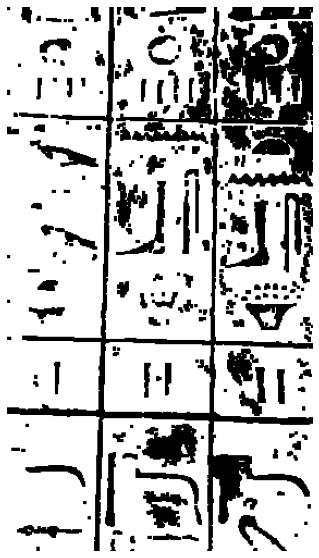

In [427]:
b,g,r = cv2.split(image)

ret, otsuthresh = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((2,2),np.uint8)
closing = cv2.morphologyEx(otsuthresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
plot_rgb(closing)
